# paint by numbers

so i got mei a paint-by-numbers since she wanted to paint with me.

to be honest, i think it's better to just paint on your own, but it's hard to get started without being able to sketch well (at least for still drawings).

i thought it would be interesting to make a paint-by-numbers notebook, where you could provide an image and it will segment everything into k-colors. i imagine a basic program would struggle with boundaries, but i want to see how far you can get with a basic implementation.

In [1]:
! pip install opencv-python pillow


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


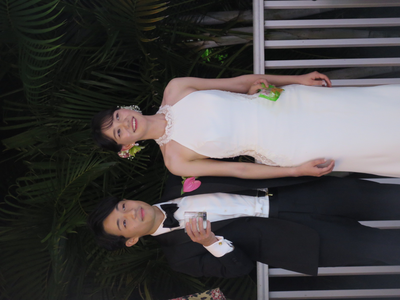

In [2]:
import PIL.Image
def open_image(image_path: str, max_size: int = 400) -> PIL.Image.Image:
    """Opens and downsizes an image using Pillow if needed.
    
    Args:
        image_path: Path to the image file
        max_size: Maximum dimension (width or height) for the image
        
    Returns:
        PIL.Image.Image: The opened and potentially downsized image
    """
    img = PIL.Image.open(image_path)
    
    # Get current dimensions
    width, height = img.size
    
    # Calculate new dimensions while maintaining aspect ratio
    if width > max_size or height > max_size:
        if width > height:
            new_width = max_size
            new_height = int((height * max_size) / width)
        else:
            new_height = max_size
            new_width = int((width * max_size) / height)
            
        img = img.resize((new_width, new_height), PIL.Image.Resampling.LANCZOS)
        
    return img

img = open_image("/Users/jeffhara/Downloads/mei_jeff.JPEG")
img

In [3]:
import numpy as np
from sklearn.mixture import GaussianMixture
import cv2

def paint_by_numbers(image: PIL.Image.Image, n_colors: int = 8, smoothing: int = 5) -> PIL.Image.Image:
    """Creates a paint-by-numbers style image using Gaussian Mixture Model clustering.
    
    This approach tends to produce better results than k-means because:
    1. It accounts for color variance/distribution rather than just distance
    2. It can handle overlapping color clusters
    3. It's more robust to initialization
    
    Args:
        image: Input PIL image
        n_colors: Number of colors to segment into
        smoothing: Size of smoothing kernel for edge preservation
        
    Returns:
        PIL.Image.Image: The paint-by-numbers style image
    """
    # Convert to numpy array and reshape for clustering
    img_array = np.array(image)
    original_shape = img_array.shape
    pixels = img_array.reshape(-1, 3)
    
    # Apply slight blur to reduce noise while preserving edges
    smoothed = cv2.bilateralFilter(img_array, smoothing, 75, 75)
    pixels_smooth = smoothed.reshape(-1, 3)
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_colors, random_state=42)
    gmm.fit(pixels_smooth)
    
    # Get cluster centers and labels
    labels = gmm.predict(pixels)
    centers = gmm.means_
    
    # Create segmented image
    segmented = centers[labels].reshape(original_shape)
    
    # Convert back to PIL Image
    return PIL.Image.fromarray(segmented.astype(np.uint8))


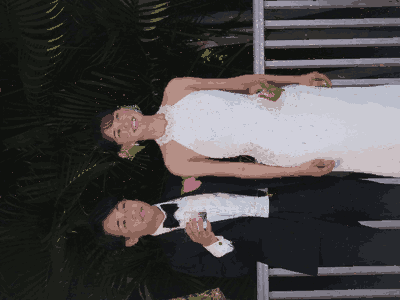

In [4]:
paint_by_numbers(img, 24)

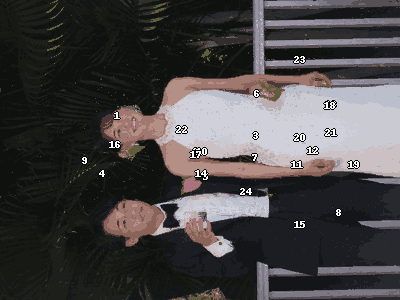

In [6]:
def paint_by_numbers_with_labels(image: PIL.Image.Image, n_colors: int = 8, smoothing: int = 5) -> PIL.Image.Image:
    """Creates a paint-by-numbers style image with numbered sections.
    
    Similar to paint_by_numbers but adds numeric labels to each color region.
    
    Args:
        image: Input PIL image
        n_colors: Number of colors to segment into
        smoothing: Size of smoothing kernel for edge preservation
        
    Returns:
        PIL.Image.Image: The paint-by-numbers style image with numeric labels
    """
    # Get base segmented image
    img_array = np.array(image)
    original_shape = img_array.shape
    pixels = img_array.reshape(-1, 3)
    
    # Apply smoothing
    smoothed = cv2.bilateralFilter(img_array, smoothing, 75, 75)
    pixels_smooth = smoothed.reshape(-1, 3)
    
    # Fit GMM and get labels
    gmm = GaussianMixture(n_components=n_colors, random_state=42)
    gmm.fit(pixels_smooth)
    labels = gmm.predict(pixels)
    centers = gmm.means_
    
    # Create segmented image
    segmented = centers[labels].reshape(original_shape)
    segmented_img = PIL.Image.fromarray(segmented.astype(np.uint8))
    
    # Add numeric labels to regions
    from PIL import ImageDraw
    draw = ImageDraw.Draw(segmented_img)
    labels_2d = labels.reshape(original_shape[:-1])
    
    # Find centers of each region to place numbers
    for label_num in range(n_colors):
        y_coords, x_coords = np.where(labels_2d == label_num)
        if len(x_coords) > 0:  # Only add label if region exists
            center_x = int(np.mean(x_coords))
            center_y = int(np.mean(y_coords))
            # Draw white text with black outline for visibility
            draw.text((center_x-1, center_y), str(label_num+1), fill='black')
            draw.text((center_x+1, center_y), str(label_num+1), fill='black')
            draw.text((center_x, center_y-1), str(label_num+1), fill='black')
            draw.text((center_x, center_y+1), str(label_num+1), fill='black')
            draw.text((center_x, center_y), str(label_num+1), fill='white')
    
    return segmented_img

# Display numbered version
paint_by_numbers_with_labels(img, 24)
